<a href="https://colab.research.google.com/github/manjunathsirur1994/Time_series_forecasting/blob/main/TS_SARIMA_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import yfinance as yf

In [60]:
ticker = 'LLOYDSME.NS'

df = yf.download(ticker, start='2000-01-01', multi_level_index=False)
df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2023-07-17 00:00:00+00:00,562.558289,563.299988,582.700012,550.500000,554.000000,417232
2023-07-18 00:00:00+00:00,543.583313,544.299988,573.900024,531.000000,573.900024,284708
2023-07-19 00:00:00+00:00,565.504395,566.250000,572.000000,541.250000,564.700012,208966
2023-07-20 00:00:00+00:00,563.307312,564.049988,572.700012,557.000000,572.700012,108284
2023-07-21 00:00:00+00:00,557.964355,558.700012,564.500000,550.049988,564.500000,189224


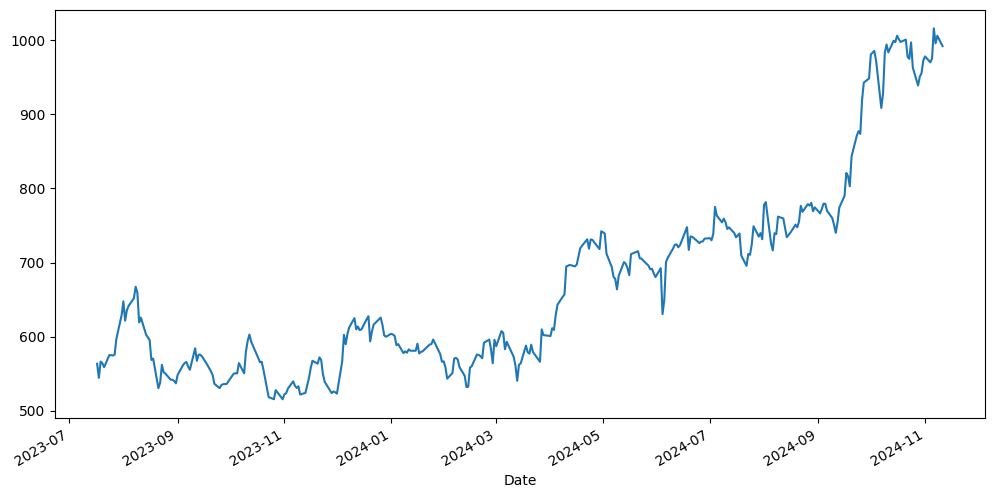

In [61]:
df['Close'].plot(figsize=(12,6));

In [62]:
df.shape

(326, 6)

In [63]:
df = df.resample("B").last()
df.shape

(346, 6)

In [64]:
df.fillna(method='ffill', inplace=True)
df.shape

<ipython-input-64-1df6602c9f4d>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


(346, 6)

In [65]:
df.isna().sum()

,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [66]:
ts = df[['Close']]
ts.head()

,Close
Date,
2023-07-17 00:00:00+00:00,563.299988
2023-07-18 00:00:00+00:00,544.299988
2023-07-19 00:00:00+00:00,566.250000
2023-07-20 00:00:00+00:00,564.049988
2023-07-21 00:00:00+00:00,558.700012


In [67]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts['Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values:{result[4]}')

ADF Statistic: 0.11203835208405209
p-value: 0.9668734618539745
Critical Values:{'1%': -3.4494474563375737, '5%': -2.8699542285903887, '10%': -2.5712527305187987}


In [68]:
ts['close_diff'] = ts['Close'].diff()
ts.dropna(inplace=True)
ts.shape

<ipython-input-68-d9944f5a6e05>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['close_diff'] = ts['Close'].diff()
<ipython-input-68-d9944f5a6e05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts.dropna(inplace=True)


(345, 2)

In [69]:
results = adfuller(ts['close_diff'])
print(f'ADF Statistic: {results[0]}')
print(f'p-value: {results[1]}')
print(f'Critical Values:{results[4]}')

ADF Statistic: -14.449286710938084
p-value: 7.142819541470987e-27
Critical Values:{'1%': -3.449559661646851, '5%': -2.8700035112469626, '10%': -2.5712790073013796}


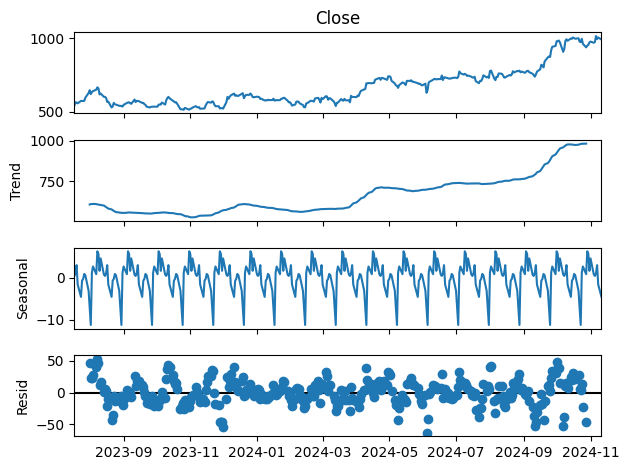

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ts['Close'], model='additive', period=20)
result.plot();

<ipython-input-71-318f7c0b0101>:8: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/np.abs(fft_freq), np.abs(fft_vals))


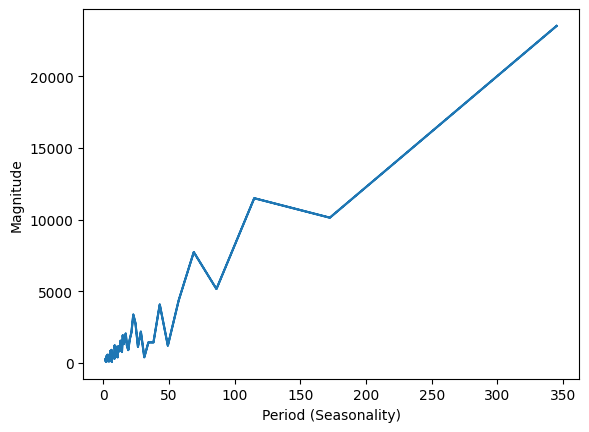

In [71]:
import numpy as np
import matplotlib.pyplot as plt

fft_vals = np.fft.fft(ts['Close'])
fft_freq = np.fft.fftfreq(len(fft_vals))

# Plot the magnitudes of the FFT to find the dominant frequency
plt.plot(1/np.abs(fft_freq), np.abs(fft_vals))
plt.xlabel('Period (Seasonality)')
plt.ylabel('Magnitude')
plt.show()

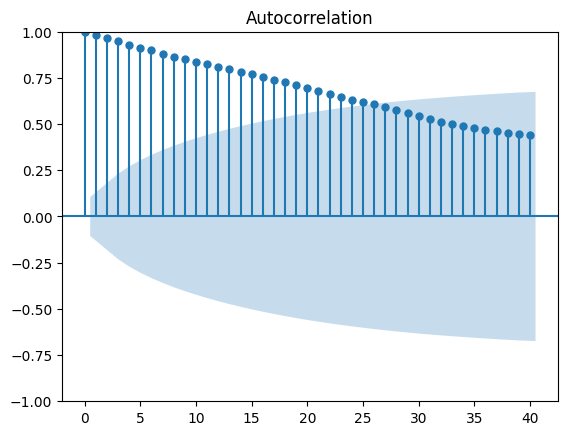

In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(ts['Close'], lags=40)  # Adjust lags to view multiple cycles
plt.show()

In [73]:
ts.shape

(345, 2)

In [74]:
df_train = ts.head(300)
df_test = ts.tail(45)

In [75]:
from statsmodels.tsa.statespace import sarimax
import itertools

model_params = {}
P=D=Q = range(0,2)
S = [20]
PDQ = list(itertools.product(P,D,Q,S))

for params in PDQ:
  try:
    model = sarimax.SARIMAX(df_train['Close'], order=(0,1,3), seasonal_order=(params))
    model_fit = model.fit()
    model_params[params] = model_fit.aic
  except:
    print("error")

In [76]:
min(model_params, key=model_params.get)

(0, 1, 1, 20)

In [77]:
model = sarimax.SARIMAX(df_train['Close'], order=(0,1,3), seasonal_order=(0,1,1,20)) # to find pdq value build arima model first then take optimal pdq value.
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                  300
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 20)   Log Likelihood               -1168.849
Date:                              Mon, 11 Nov 2024   AIC                           2347.698
Time:                                      11:21:27   BIC                           2365.854
Sample:                                  07-18-2023   HQIC                          2354.981
                                       - 09-09-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0406      0.060     -0.674      0.500      -0.158       0.077
ma.L2         -0.0576      0.045     -1.275      0.202      -0.146       0.031
ma.L3          0.0146      0.075      0.195      0.846      -0.132       0.161
ma.S.L20      -0.9805      0.289     -3.397      0.001      -1.546      -0.415
sigma2       214.0122     54.465      3.929      0.000     107.263     320.761
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                44.98
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.03
Prob(H) (two-sided):                  0.52   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
y_pred = model_fit.predict(start=df_test.index[0], end=df_test.index[-1])
y_pred.head()

,predicted_mean
2024-09-10 00:00:00+00:00,761.386634
2024-09-11 00:00:00+00:00,762.147785
2024-09-12 00:00:00+00:00,763.399217
2024-09-13 00:00:00+00:00,758.700263
2024-09-16 00:00:00+00:00,755.609587


In [79]:
df_test['Close'].head()

,Close
Date,
2024-09-10 00:00:00+00:00,750.750000
2024-09-11 00:00:00+00:00,740.000000
2024-09-12 00:00:00+00:00,754.299988
2024-09-13 00:00:00+00:00,774.099976
2024-09-16 00:00:00+00:00,790.000000


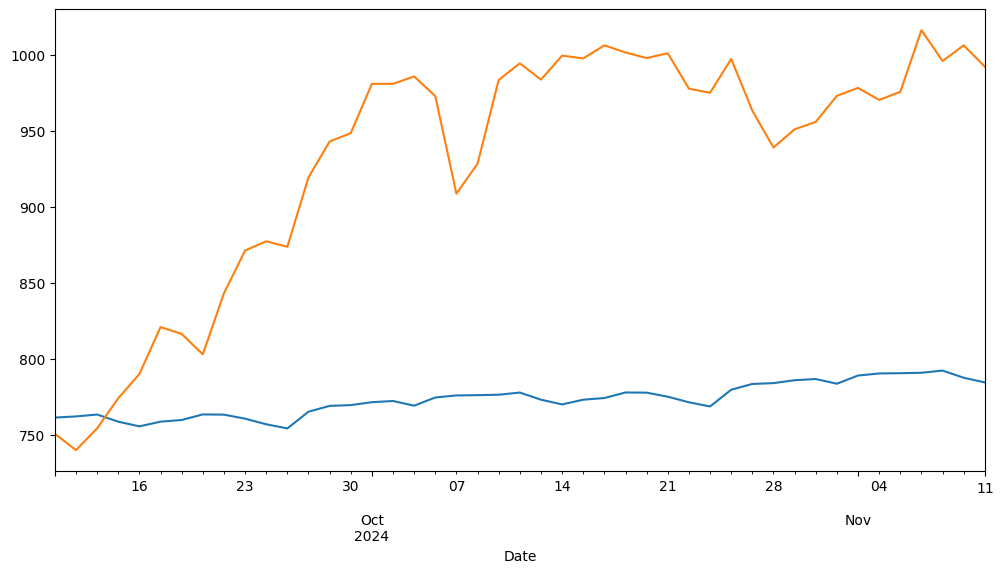

In [80]:
y_pred.plot(figsize=(12,6))
df_test['Close'].plot();

In [81]:
from sklearn.metrics import mean_squared_error

mean_squared_error(df_test['Close'], y_pred)

30286.427279165004

In [82]:
import math

math.sqrt(mean_squared_error(df_test['Close'], y_pred))

174.02996086641232

In [83]:
# USING EXOGENOUS VARIABLES TO THE MODEL

In [84]:
ticker = 'LLOYDSME.NS'

df = yf.download(ticker, start='2000-01-01', multi_level_index=False)
df

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2023-07-17 00:00:00+00:00,562.558289,563.299988,582.700012,550.500000,554.000000,417232
2023-07-18 00:00:00+00:00,543.583313,544.299988,573.900024,531.000000,573.900024,284708
2023-07-19 00:00:00+00:00,565.504395,566.250000,572.000000,541.250000,564.700012,208966
2023-07-20 00:00:00+00:00,563.307312,564.049988,572.700012,557.000000,572.700012,108284
2023-07-21 00:00:00+00:00,557.964355,558.700012,564.500000,550.049988,564.500000,189224
...,...,...,...,...,...,...
2024-11-05 00:00:00+00:00,975.500000,975.500000,987.599976,966.950012,970.250000,156433
2024-11-06 00:00:00+00:00,1016.049988,1016.049988,1020.000000,971.150024,971.150024,429220
2024-11-07 00:00:00+00:00,995.750000,995.750000,1030.000000,990.000000,1014.500000,178607


In [85]:
df = df.resample("B").last()
df.fillna(method='ffill', inplace=True)
df = df[['Close']]
df

<ipython-input-85-0cb21e3ba9b5>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,Close
Date,
2023-07-17 00:00:00+00:00,563.299988
2023-07-18 00:00:00+00:00,544.299988
2023-07-19 00:00:00+00:00,566.250000
2023-07-20 00:00:00+00:00,564.049988
2023-07-21 00:00:00+00:00,558.700012
...,...
2024-11-05 00:00:00+00:00,975.500000
2024-11-06 00:00:00+00:00,1016.049988
2024-11-07 00:00:00+00:00,995.750000


In [86]:
# df['Close_diff'] = df['Close'].diff() # You cannot use this feature since it will not be present in the future.
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['day_name'] = df.index.day_name()
df['quarter'] = df.index.quarter
df['dayofyear'] = df.index.dayofyear
df['isweekend'] = df['dayofweek'] >= 5
df = df.dropna()
df

,Close,year,month,day,dayofweek,day_name,quarter,dayofyear,isweekend
Date,,,,,,,,,
2023-07-17 00:00:00+00:00,563.299988,2023,7,17,0,Monday,3,198,False
2023-07-18 00:00:00+00:00,544.299988,2023,7,18,1,Tuesday,3,199,False
2023-07-19 00:00:00+00:00,566.250000,2023,7,19,2,Wednesday,3,200,False
2023-07-20 00:00:00+00:00,564.049988,2023,7,20,3,Thursday,3,201,False
2023-07-21 00:00:00+00:00,558.700012,2023,7,21,4,Friday,3,202,False
...,...,...,...,...,...,...,...,...,...
2024-11-05 00:00:00+00:00,975.500000,2024,11,5,1,Tuesday,4,310,False
2024-11-06 00:00:00+00:00,1016.049988,2024,11,6,2,Wednesday,4,311,False
2024-11-07 00:00:00+00:00,995.750000,2024,11,7,3,Thursday,4,312,False


In [87]:
import pandas as pd

dummies = pd.get_dummies(df['day_name'])
df.drop(columns=['day_name'], inplace=True)
df = pd.concat([df, dummies], axis=1)
df

,Close,year,month,day,dayofweek,quarter,dayofyear,isweekend,Friday,Monday,Thursday,Tuesday,Wednesday
Date,,,,,,,,,,,,,
2023-07-17 00:00:00+00:00,563.299988,2023,7,17,0,3,198,False,False,True,False,False,False
2023-07-18 00:00:00+00:00,544.299988,2023,7,18,1,3,199,False,False,False,False,True,False
2023-07-19 00:00:00+00:00,566.250000,2023,7,19,2,3,200,False,False,False,False,False,True
2023-07-20 00:00:00+00:00,564.049988,2023,7,20,3,3,201,False,False,False,True,False,False
2023-07-21 00:00:00+00:00,558.700012,2023,7,21,4,3,202,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-05 00:00:00+00:00,975.500000,2024,11,5,1,4,310,False,False,False,False,True,False
2024-11-06 00:00:00+00:00,1016.049988,2024,11,6,2,4,311,False,False,False,False,False,True
2024-11-07 00:00:00+00:00,995.750000,2024,11,7,3,4,312,False,False,False,True,False,False


In [88]:
df.replace({True:1, False:0}, inplace=True)
df

<ipython-input-88-a3aea8266526>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True:1, False:0}, inplace=True)


,Close,year,month,day,dayofweek,quarter,dayofyear,isweekend,Friday,Monday,Thursday,Tuesday,Wednesday
Date,,,,,,,,,,,,,
2023-07-17 00:00:00+00:00,563.299988,2023,7,17,0,3,198,0,0,1,0,0,0
2023-07-18 00:00:00+00:00,544.299988,2023,7,18,1,3,199,0,0,0,0,1,0
2023-07-19 00:00:00+00:00,566.250000,2023,7,19,2,3,200,0,0,0,0,0,1
2023-07-20 00:00:00+00:00,564.049988,2023,7,20,3,3,201,0,0,0,1,0,0
2023-07-21 00:00:00+00:00,558.700012,2023,7,21,4,3,202,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-05 00:00:00+00:00,975.500000,2024,11,5,1,4,310,0,0,0,0,1,0
2024-11-06 00:00:00+00:00,1016.049988,2024,11,6,2,4,311,0,0,0,0,0,1
2024-11-07 00:00:00+00:00,995.750000,2024,11,7,3,4,312,0,0,0,1,0,0


In [89]:
df.shape

(346, 13)

In [90]:
df_train = df.head(340)
df_test = df.tail(6)

In [91]:
from statsmodels.tsa.statespace import sarimax

model = sarimax.SARIMAX(df_train['Close'],
                        order=(0,1,3),
                        seasonal_order=(0,1,1,20),
                        exog=df_train.drop(columns=['Close']))                           # to find pdq value build arima model first then take optimal pdq value.
model_fit = model.fit()                                                                  # to find PDQ value use the above itertools method to find the optimal PDQ and then use here
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                  340
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 20)   Log Likelihood               -1353.705
Date:                              Mon, 11 Nov 2024   AIC                           2741.410
Time:                                      11:22:00   BIC                           2805.418
Sample:                                  07-17-2023   HQIC                          2766.972
                                       - 11-01-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          -6.0612     35.414     -0.171      0.864     -75.470      63.348
month       -149.5596    460.949     -0.324      0.746   -1053.003     753.884
day           -5.0062     14.907     -0.336      0.737     -34.223      24.210
dayofweek      0.0166   6532.916   2.54e-06      1.000   -1.28e+04    1.28e+04
quarter        6.2292     15.161      0.411      0.681     -23.486      35.945
dayofyear      4.8527     15.073      0.322      0.747     -24.689      34.395
isweekend           0        nan        nan        nan         nan         nan
Friday     -7.854e-05   2.47e+04  -3.18e-09      1.000   -4.84e+04    4.84e+04
Monday        -0.0058   2.35e+04  -2.45e-07      1.000   -4.61e+04    4.61e+04
Thursday       0.0087   2.49e+04   3.52e-07      1.000   -4.87e+04    4.87e+04
Tuesday       -0.0024   2.34e+04  -1.05e-07      1.000   -4.59e+04    4.59e+04
Wednesday     -0.0035   2.53e+04  -1.36e-07      1.000   -4.97e+04    4.97e+04
ma.L1          0.0256      0.056      0.459      0.646      -0.084       0.135
ma.L2         -0.0804      0.051     -1.592      0.111      -0.179       0.019
ma.L3          0.0175      0.070      0.251      0.802      -0.119       0.154
ma.S.L20      -0.8899      0.062    -14.292      0.000      -1.012      -0.768
sigma2       256.9945     17.234     14.912      0.000     223.216     290.773
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                47.26
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                            -0.09
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.44e+24. Standard errors may be unstable.
"""

In [92]:
df_train.tail(1)

,Close,year,month,day,dayofweek,quarter,dayofyear,isweekend,Friday,Monday,Thursday,Tuesday,Wednesday
Date,,,,,,,,,,,,,
2024-11-01 00:00:00+00:00,978.099976,2024,11,1,4,4,306,0,1,0,0,0,0


In [93]:
df_test

,Close,year,month,day,dayofweek,quarter,dayofyear,isweekend,Friday,Monday,Thursday,Tuesday,Wednesday
Date,,,,,,,,,,,,,
2024-11-04 00:00:00+00:00,970.150024,2024,11,4,0,4,309,0,0,1,0,0,0
2024-11-05 00:00:00+00:00,975.500000,2024,11,5,1,4,310,0,0,0,0,1,0
2024-11-06 00:00:00+00:00,1016.049988,2024,11,6,2,4,311,0,0,0,0,0,1
2024-11-07 00:00:00+00:00,995.750000,2024,11,7,3,4,312,0,0,0,1,0,0
2024-11-08 00:00:00+00:00,1006.049988,2024,11,8,4,4,313,0,1,0,0,0,0
2024-11-11 00:00:00+00:00,992.000000,2024,11,11,0,4,316,0,0,1,0,0,0


In [94]:
# import numpy as np                                              # reshaping exog data in numpy since we have only 1 value to predict
exog_data = df_test.drop(columns=['Close'])
# exog_data = np.repeat(exog_data.values, 2, axis=0)

In [96]:
y_pred = model_fit.predict(start=df_test.index[0], end=df_test.index[-1], exog=exog_data)
y_pred.head()

,predicted_mean
2024-11-04 00:00:00+00:00,968.913227
2024-11-05 00:00:00+00:00,969.739226
2024-11-06 00:00:00+00:00,973.603704
2024-11-07 00:00:00+00:00,977.991609
2024-11-08 00:00:00+00:00,975.027318


In [97]:
from sklearn.metrics import mean_squared_error
import math

mean_squared_error(df_test['Close'], y_pred)

562.6048438712606

In [98]:
math.sqrt(mean_squared_error(df_test['Close'], y_pred))

23.719292651157637